# Inclination Change

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as  plt
import matplotlib.dates as mdates
import mplcursors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker

import models
from maneuvers import Maneuvers
from coordinates import cart2kep
from constants import constants
import auxiliary

In [2]:
%matplotlib notebook

In [9]:
#----- INITIAL CONDITIONS -----
# Explicit conditions
rp = constants.Re+50000e3
ra = constants.Re+50001e3
Omega = 30*np.pi/180
i = 2*np.pi/180#65.1*np.pi/180
omega = 30*np.pi/180
M = 332*np.pi/180
#-------------------
# Derived conditions
e = (ra-rp)/(ra+rp)
a = (ra+rp)/2
#--------------------
# Final conditions
coe = [a,e,i,omega,Omega,M]
date = datetime.now()
#coe,date = helpers.parseTle("suchai0.tle")

#----- SPACECRAFT DEFINITIONS -----
satellite = models.Cubesat("3U")
thruster = models.Thruster(thrust=5e-2,isp=720)
satellite.thruster = thruster

# ---- MANEUVERING ------
maneuvers = Maneuvers(coe,satellite,date)
#maneuvers.addPerturbation("atmosphere")
maneuvers.propagate2(60*60*24*1)

#maneuvers.addPerturbation("J2")
#maneuvers.addPerturbation("moon_gravity")
#maneuvers.addPerturbation("sun_gravity")
#maneuvers.addPerturbation("solar_pressure")
maneuvers.addPerturbation("thrust")
%time maneuvers.propagate2(60*60*18)
maneuvers.removePerturbation("thrust")
maneuvers.propagate2(60*60*24*1)

Propagating...from day  0.0  to  1.0
Propagating...from day  1.0  to  1.75
Wall time: 188 ms
Propagating...from day  1.75  to  2.75


<IPython.core.display.Javascript object>


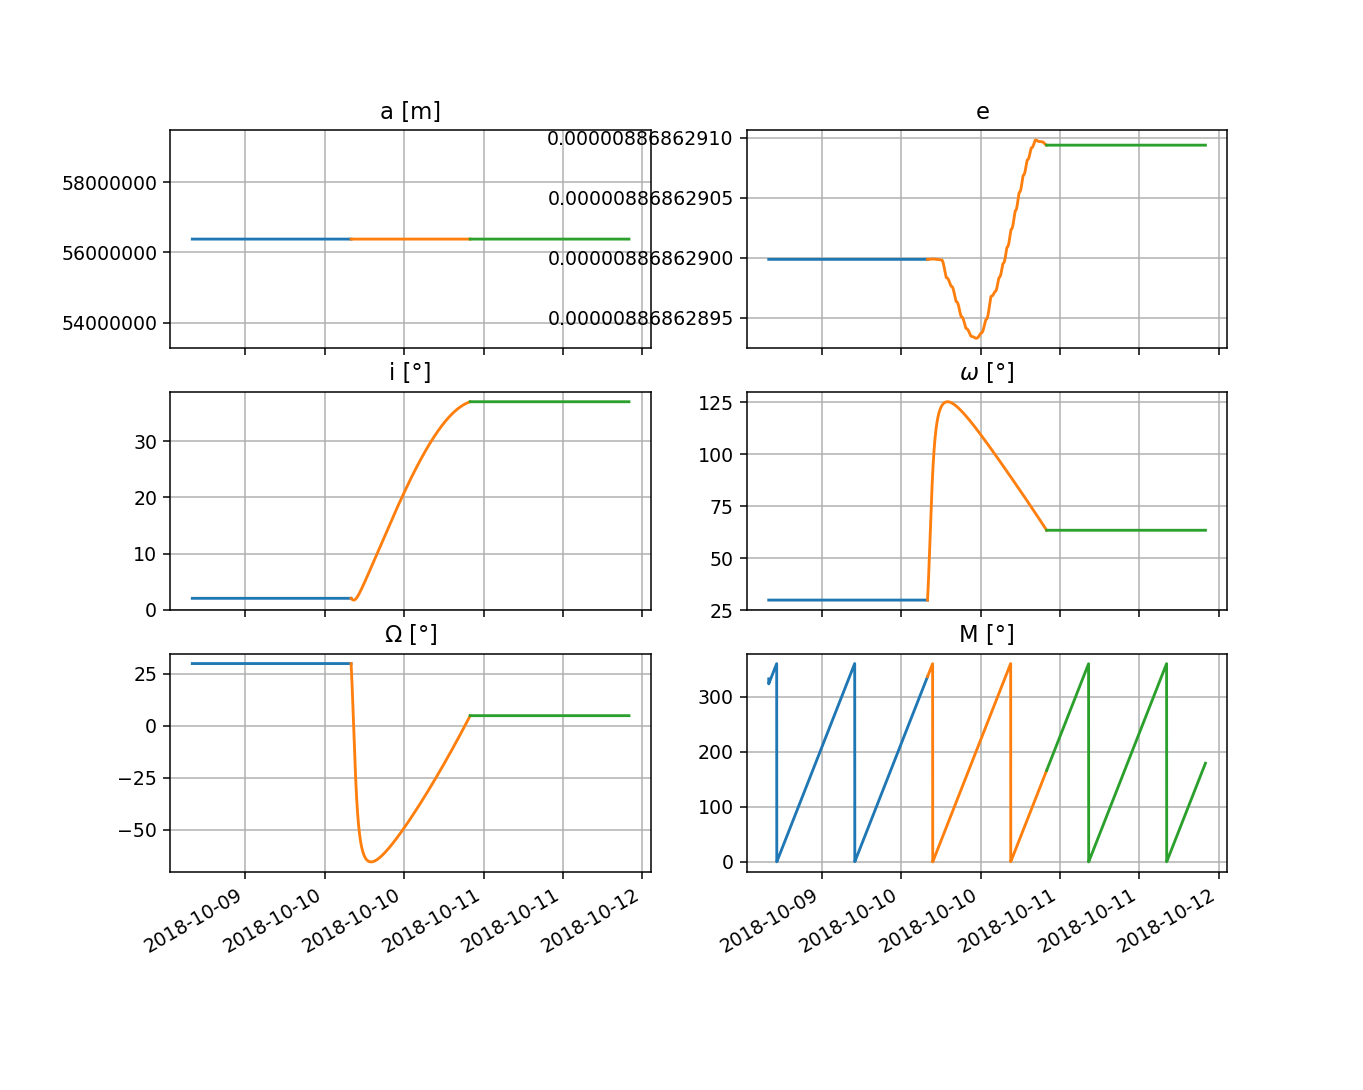

In [5]:
maneuvers.plot("com");

<IPython.core.display.Javascript object>


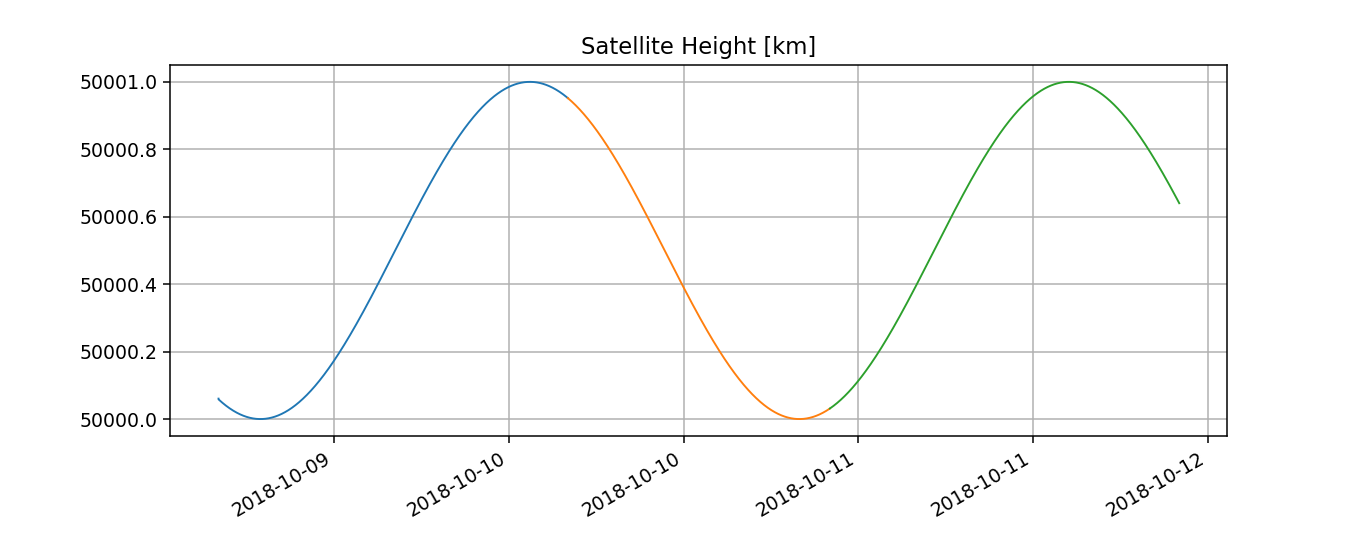

<IPython.core.display.Javascript object>


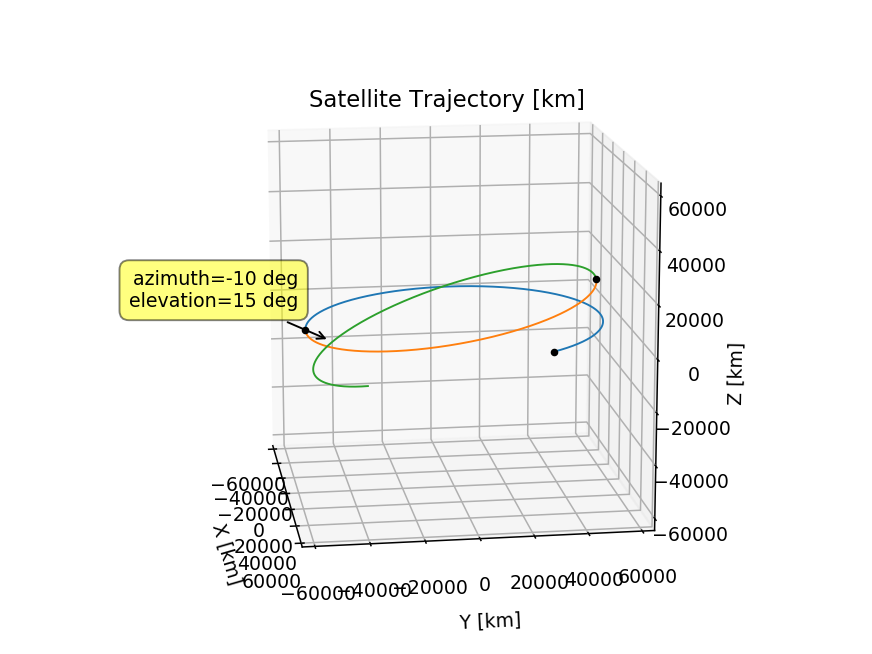

<IPython.core.display.Javascript object>


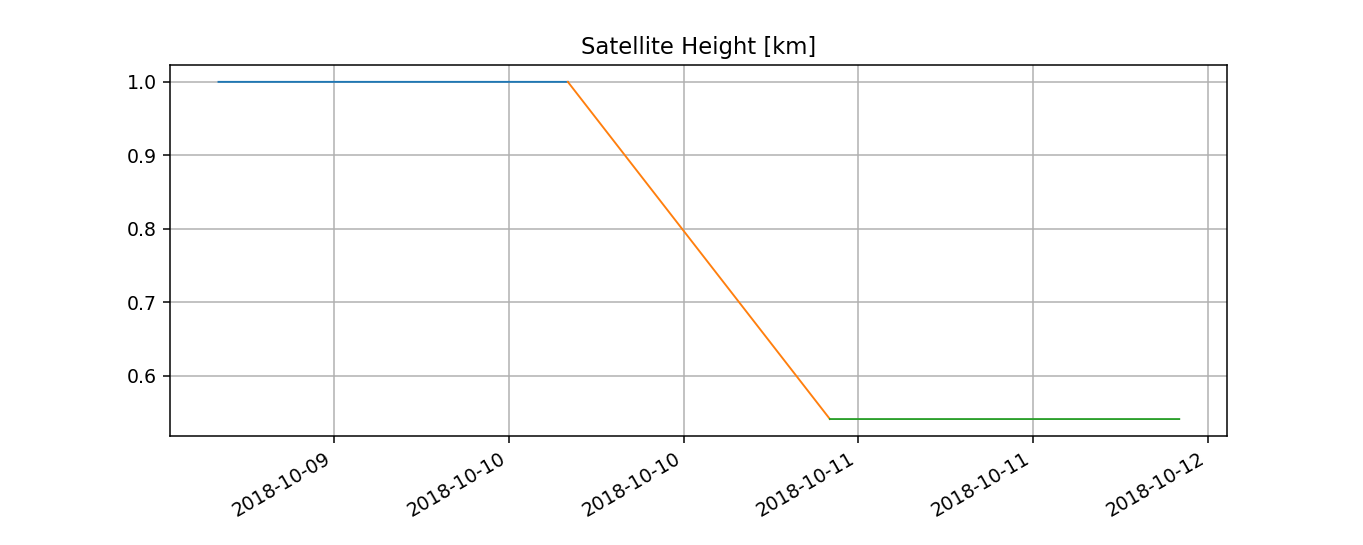

In [10]:
maneuvers.plot("singleItem", (np.linalg.norm(maneuvers.history.r,axis=1)-constants.Re)/1000)
maneuvers.plot("3d-trajectory")
maneuvers.plot("singleItem", maneuvers.history.propMass)